### Clone GitHub repository

In [40]:
!git clone https://github.com/vagmarting/TM10007_Group_8.git

fatal: destination path 'TM10007_Group_8' already exists and is not an empty directory.


### Import

In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score


### Load data

In [42]:
def load_data():
    data = pd.read_csv(os.path.join('hn','HN_radiomicFeatures.csv'), index_col=0)
    label = data["label"]
    label = label.replace(to_replace={'T12': False, 'T34': True}, value=None)
    data = data.drop(["label"], axis=1)
    feature_names = data.columns.values
    return data, label, feature_names

data, label, feature_names = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 113
The number of columns: 159


### Check for missing data

In [43]:
# Detect missing values in dataframe
data.isnull().values.any()

False

### Data split

In [44]:
def split_data(data, label):
    train_data, test_data, train_label, test_label = train_test_split(data, label, train_size=0.7, stratify=label)
    return train_data, test_data, train_label, test_label

train_data, test_data, train_label, test_label = split_data(data, label)
print(f'The number of train samples: {train_data.shape[0]}')
print(f'The number of test samples: {test_data.shape[0]}')

The number of train samples: 79
The number of test samples: 34


### Change outliers to median of the feature

In [45]:
def preprocessing(train_data, test_data, train_label, test_label):
    # Remove features with zero variance
    selector = VarianceThreshold()
    selector.fit_transform(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data.drop(zero_var_col, inplace=True, axis=1)
    test_data.drop(zero_var_col, inplace=True, axis=1)
    

    # Impute median value of feature for outliers
    column_medians = train_data.median()
    train_values = train_data.values
    test_values = test_data.values
    train_mean = train_data.mean()
    train_std = train_data.std()

    for i in range(len(train_values)):
        for j in range(len(train_values[0])):
            if np.abs((train_values[i,j] - train_mean[j]) / train_std[j]) > 3:
                train_values[i,j] = column_medians[j]
    train_data = pd.DataFrame(train_values, columns=train_label)

    for i in range(len(test_values)):
        for j in range(len(test_values[0])):
            if np.abs((test_values[i,j] - train_mean[j]) / train_std[j]) > 3:
                test_values[i,j] = column_medians[j]
    test_data = pd.DataFrame(test_values, columns=test_label)

    
    # Scale features
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    return train_data, test_data

### Scaling train data

In [46]:
def scale_data(train_data, test_data, feature_names):
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    return train_data, test_data

### Remove features with 0 variance

In [47]:
def remove_zero_var(train_data, test_data):
    selector = VarianceThreshold()
    selector.fit_transform(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data.drop(zero_var_col, inplace=True, axis=1)
    test_data.drop(zero_var_col, inplace=True, axis=1)
    return train_data, test_data


### Select best features with Anova test

In [48]:
def select_features(kbest, train_data, train_label, test_data):
    fs = SelectKBest(score_func=f_classif, k=kbest)
    kbest_train = fs.fit_transform(train_data, train_label)
    kbest_test = fs.transform(test_data)
    return kbest_train, kbest_test

### Lasso Regression

In [49]:
def lasso_regression(train_data, train_label, test_data):
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
    sel_.fit(train_data, np.ravel(train_label,order='C'))
    sel_.get_support()
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    removed_feats = train_data.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    lasso_train = train_data.drop(removed_feats, axis='columns')
    lasso_test = test_data.drop(removed_feats, axis='columns')
    return lasso_train, lasso_test

### Random Forest Classifier

In [50]:
def random_forest(train_data, test_data, train_label, test_label):
    clf = RandomForestClassifier()
    n_estimators = range(20,140,15)
    max_depth = range(8, 15, 2)
    min_samples_leaf = range(2, 7)
    min_samples_split = range(3, 10, 2)

    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split
    }

    rf_random = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=150, cv=4)
    rf_random.fit(train_data, train_label)
    
    best_params = rf_random.best_params_
    best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], min_samples_split=best_params['min_samples_split'],
                                    min_samples_leaf=best_params['min_samples_leaf'], max_depth=best_params['max_depth'])
    best_model.fit(train_data,train_label)
    rf_random_train =  best_model.predict(train_data)
    rf_random_test = best_model.predict(test_data)
    score_train = metrics.accuracy_score(train_label, rf_random_train)
    score_test = metrics.accuracy_score(test_label, rf_random_test)
    confusion_matrix_train = metrics.confusion_matrix(train_label, rf_random_train)
    confusion_matrix_test = metrics.confusion_matrix(test_label, rf_random_test)
    return score_train, score_test, confusion_matrix_train, confusion_matrix_test, best_model

### Calculate sensitivity, specificity, PPV, NPV

In [51]:
def sens_spec(confusion_matrix):
    true_neg, false_pos, false_neg, true_pos = confusion_matrix.ravel()
    sens = true_pos/(true_pos + false_neg)
    spec = true_neg/(true_neg + false_pos)
    return sens, spec

### Find average accuracy over multiple classifications

In [52]:
# Find mean accuracy for kNN classification
loops = 5
score_train_array = np.zeros(loops)
score_test_array = np.zeros(loops)
sens_train_array = np.zeros(loops)
spec_train_array = np.zeros(loops)
sens_test_array = np.zeros(loops)
spec_test_array = np.zeros(loops)

num_best_features = 80
pca_components = 10
knn_neighbors = 15

for i in range(loops):
    data, label, feature_names = load_data()
    train_data, test_data, train_label, test_label = split_data(data, label)
    train_data, test_data = preprocessing(train_data, test_data, train_label, test_label)

    # Find best features based on F-scores
    kbest_train, kbest_test = select_features(num_best_features, train_data, train_label, test_data)

    # Lasso regression
    lasso_train, lasso_test = lasso_regression(kbest_train, train_label, kbest_test)

    # Apply random forest classifier and calculate accuracy score
    score_train, score_test, confusion_matrix_train, confusion_matrix_test, best_model = random_forest(lasso_train, lasso_test, train_label, test_label)
    score_train_array[i] = score_train
    score_test_array[i] = score_test

    # Calculate sensitivity and specificity
    sens_train, spec_train = sens_spec(confusion_matrix_train)
    sens_test, spec_test = sens_spec(confusion_matrix_test)

    sens_train_array[i] = sens_train
    spec_train_array[i] = spec_train

    sens_test_array[i] = sens_test
    spec_test_array[i] = spec_test


C:\Users\velde\AppData\Local\Temp/ipykernel_24820/2844280437.py:10: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((train_values[i,j] - train_mean[j]) / train_std[j]) > 3:
C:\Users\velde\AppData\Local\Temp/ipykernel_24820/2844280437.py:16: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((test_values[i,j] - train_mean[j]) / train_std[j]) > 3:
C:\Users\velde\AppData\Local\Temp/ipykernel_24820/2844280437.py:10: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((train_values[i,j] - train_mean[j]) / train_std[j]) > 3:
C:\Users\velde\AppData\Local\Temp/ipykernel_24820/2844280437.py:16: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((test_values[i,j] - train_mean[j]) / train_std[j]) > 3:
C:\Users\velde\AppData\Local\Temp/ipykernel_24820/2844280437.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs((test_values[i,j] - train_mean[j]) / train_std[j]) > 3:
C:\Users\velde\Ap

In [53]:
# Calculate and print mean and std outcome values over all iterations
mean_score_train = np.mean(score_train_array)
mean_score_test = np.mean(score_test_array)
mean_sens_train = np.mean(sens_train_array)
mean_spec_train = np.mean(spec_train_array)
mean_sens_test = np.mean(sens_test_array)
mean_spec_test = np.mean(spec_test_array)
std_score_train = np.std(score_train_array)
std_score_test = np.std(score_test_array)
std_sens_train = np.std(sens_train_array)
std_spec_train = np.std(spec_train_array)
std_sens_test = np.std(sens_test_array)
std_spec_test = np.std(spec_test_array)
print(f"Mean training score: {mean_score_train:.2f} (std = {std_score_train:.2f})")
print(f"Mean test score: {mean_score_test:.2f} (std = {std_score_test:.2f})")
print(f"Mean train sens: {mean_sens_train:.2f} (std = {std_sens_train:.2f})")
print(f"Mean test sens: {mean_sens_test:.2f} (std = {std_sens_test:.2f})")
print(f"Mean train spec: {mean_spec_train:.2f} (std = {std_spec_train:.2f})")
print(f"Mean test spec: {mean_spec_test:.2f} (std = {std_spec_test:.2f})")

Mean training score: 0.95 (std = 0.04)
Mean test score: 0.74 (std = 0.05)
Mean train sens: 0.93 (std = 0.06)
Mean test sens: 0.76 (std = 0.12)
Mean train spec: 0.97 (std = 0.02)
Mean test spec: 0.72 (std = 0.09)


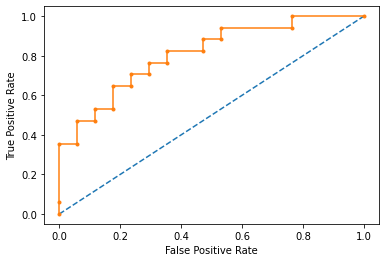

Area Under Curve = 0.81


In [54]:
# predict probabilities
yhat = best_model.predict_proba(lasso_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(test_label, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()
# auc score
roc_auc = roc_auc_score(test_label, pos_probs)
print(f"Area Under Curve = {roc_auc:.2f}")